<a href="https://colab.research.google.com/github/johntanas/it1244project/blob/main/code/model_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score,average_precision_score,plot_roc_curve

In [83]:
n_repeats=1
n_splits=5

In [84]:
path_to_max_label="../content/max_label.csv"
path_to_app="../content/cleaned_application.csv"
cleaned_app_df=pd.read_csv(path_to_app,index_col=0)
max_df=pd.read_csv(path_to_max_label,index_col=0)

In [85]:
dep_var="status"
random_state=42

Sort by median income of job to give a ordering to the jobs

In [86]:
order=cleaned_app_df.groupby("job")["income"].median().sort_values()

In [87]:
cleaned_app_df["job"]=cleaned_app_df["job"].replace(order)

In [88]:
train_df=max_df.merge(cleaned_app_df,how="inner",on="id").drop("id",axis=1)

In [89]:
numerical_transformer = StandardScaler()
categorical_transformer=OneHotEncoder()
ord_transformer=OrdinalEncoder()

In [90]:
X,y=train_df.drop(columns=dep_var),train_df[dep_var]

In [91]:
categorical_cols = [cname for cname in X.columns if X[cname].nunique() < 10 and 
                        X[cname].dtype == "object"]
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]


In [92]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('ord',ord_transformer,['job'])
    ])

In [93]:
xs=preprocessor.fit_transform(X)

In [94]:
#https://stackoverflow.com/questions/67554372/get-feature-names-of-columntransformer-using-standarscaler-and-one-hot-encoding
tx = preprocessor.get_params()['transformers']
feature_names = []
for name,transformer,features in tx:
    try:
        Var = preprocessor.named_transformers_[name].get_feature_names().tolist()
        print(Var)
    except AttributeError:
        print(features)
        Var = features
    feature_names = feature_names + Var

['num_child', 'income', 'birth_day', 'employment_length', 'work_phone', 'phone', 'email', 'job', 'CNT_FAM_MEMBERS']
['x0_F', 'x0_M', 'x1_N', 'x1_Y', 'x2_N', 'x2_Y', 'x3_Commercial associate', 'x3_Pensioner', 'x3_State servant', 'x3_Student', 'x3_Working', 'x4_Academic degree', 'x4_Higher education', 'x4_Incomplete higher', 'x4_Lower secondary', 'x4_Secondary / secondary special', 'x5_Civil marriage', 'x5_Married', 'x5_Separated', 'x5_Single / not married', 'x5_Widow', 'x6_Co-op apartment', 'x6_House / apartment', 'x6_Municipal apartment', 'x6_Office apartment', 'x6_Rented apartment', 'x6_With parents']
['job']


c:\Users\siong hwee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [95]:
score_df=pd.DataFrame()

We will be doing cross validation with StratifiedKFold =5 and 5 repeats.
We use StratifiedKFold instead of Kfold to perserve  the percentage of samples for each class.

In [96]:
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

In [97]:
# dataframe of scores to be converted into plot later
score_df=pd.DataFrame()


* AUC is classification-threshold-invariant. It measures the quality of the model's predict_probaions irrespective of what classification threshold is chosen. 
https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
* Thus we choose AUC as the banks who use the models can determine their own threshold risk probability for bad users and calculate their expected value/loss for these bad users and give them an appropriate interest rate when extending credit to them


There is very little linearity in the imbalanced dataset for the linear dividing line of logisitic regression to work on. This can be seen from the low level of correlation in the table below where all variables have correlation between -0.03 and 0.03 and logisitic regression will be similar to random guessing so we do not try logisitic regression

(array([0.5]), [Text(0.5, 0, 'status')])

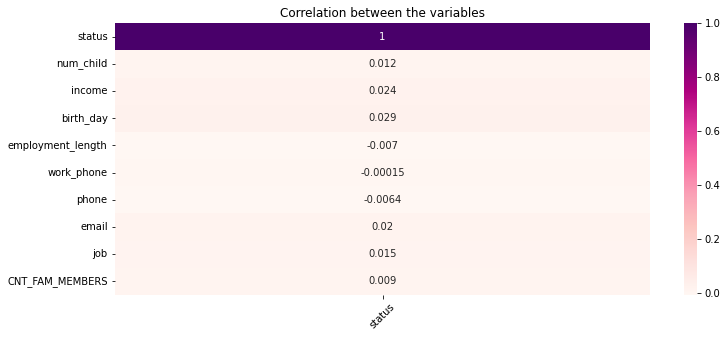

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.subplots(figsize=(12,5))
status_correlation=train_df.corr()[["status"]]
sns.heatmap(status_correlation,annot=True,cmap='RdPu')
plt.title('Correlation between the variables')
plt.xticks(rotation=45)

We cannot choose k= sqrt(len(X_train)) as it would be very hard to detect the minority class

In [99]:
# try different K values
bestscore=0
bestmodel,bestmodel_val_data=None,None
for i in range(1,10,2):
    scores=[]
    for train_index, test_index in cv.split(xs,y):
          X_train = xs[train_index]
          y_train = y[train_index]
          X_test = xs[test_index]
          y_test = y[test_index]
          model = KNeighborsClassifier(i)
          model.fit(X_train, y_train)  
          y_pred = model.predict_proba(X_test)[:,1]
          score=roc_auc_score(y_test,y_pred)
          if score>bestscore:
              bestmodel=model
              bestscore,bestmodel_val_data=score,[y_test,X_test]
              print(f"KNN {i} with best score of {score}")
          scores.append(roc_auc_score(y_test,y_pred))
    score_df["KNN"+str(i)]=scores
    print(f"KNN {i} with avg score of {np.median(np.array(scores))}")

KNN 1 with best score of 0.6386681775992423
KNN 1 with best score of 0.6519747219933729
KNN 1 with best score of 0.6584954762321464
KNN 1 with avg score of 0.6468466255534953
KNN 3 with best score of 0.7124619544849056
KNN 3 with best score of 0.7131018525563133
KNN 3 with best score of 0.7255640623431701
KNN 3 with best score of 0.7267859996369246
KNN 3 with best score of 0.7275291456830838
KNN 3 with best score of 0.7291942732639141
KNN 3 with avg score of 0.7200786156172446
KNN 5 with best score of 0.7364238952922304
KNN 5 with best score of 0.7373333050699754
KNN 5 with avg score of 0.7249398157456088
KNN 7 with avg score of 0.7163362225515374
KNN 9 with avg score of 0.7079304446007384


c:\Users\siong hwee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


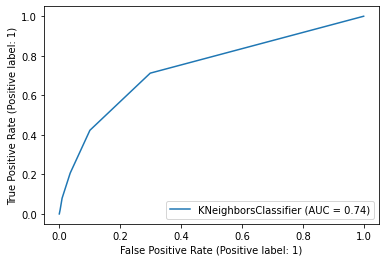

In [100]:
y_test,X_test=bestmodel_val_data
plot_roc_curve(bestmodel,X_test,y_test)

Knn with small K <5 is more senstitive to noise while k=5 is the best spot and the roc drops off after k=5.

In [101]:
bestscore=0
bestmodel,bestmodel_val_data=None,None
scores=[]
for train_index, test_index in cv.split(xs,y):
      X_train = xs[train_index]
      y_train = y[train_index]
      X_test = xs[test_index]
      y_test = y[test_index]
      model = RandomForestClassifier(random_state=random_state,class_weight ="balanced_subsample")
      model.fit(X_train, y_train )  
      y_pred = model.predict_proba(X_test)[:,1]
      score=roc_auc_score(y_test,y_pred)
      if score>bestscore:
          bestmodel=model
          bestscore,bestmodel_val_data=score,[y_test,X_test]
          print(f"RandomForestClassifier with best score of {score}")
      scores.append(roc_auc_score(y_test,y_pred))
score_df["RandomForestClassifier"]=scores
print(f"RandomForestClassifier with avg score of {np.median(np.array(scores))}")

RandomForestClassifier with best score of 0.7857493928190047
RandomForestClassifier with best score of 0.7911778409136198
RandomForestClassifier with best score of 0.7975426821999183
RandomForestClassifier with best score of 0.799740882983538
RandomForestClassifier with avg score of 0.7909031483569025


In [102]:

def rf_feat_importance(m, feature_names):
    return pd.DataFrame({'cols':feature_names, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi = rf_feat_importance(bestmodel, feature_names)
fi[:10]

,cols,imp
2,birth_day,0.215812
3,employment_length,0.184822
1,income,0.149824
36,job,0.038430
7,job,0.038228
8,CNT_FAM_MEMBERS,0.036151
5,phone,0.027574
0,num_child,0.026703
4,work_phone,0.021517
24,x4_Secondary / secondary special,0.016679


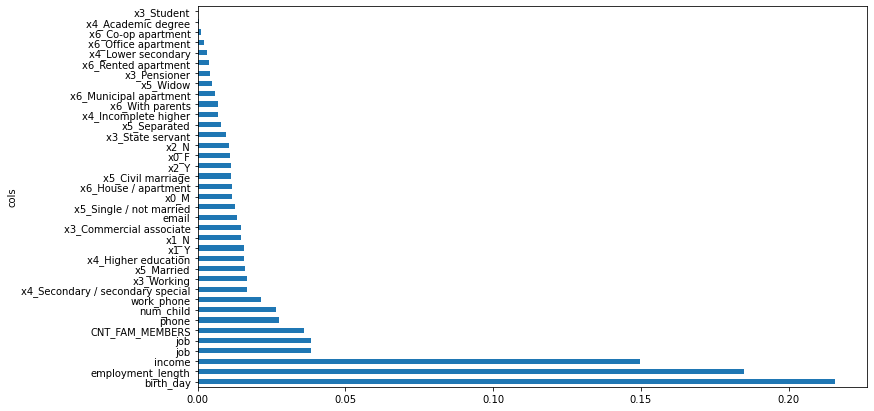

In [103]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi);


birthday , employment length and income are the strong learners for the random forest. The random forest is able to differentiate using these variables

c:\Users\siong hwee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


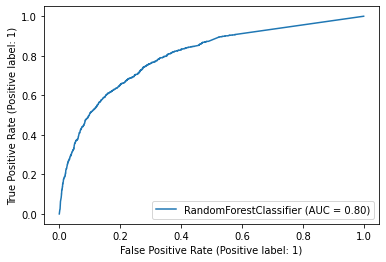

In [104]:
y_test,X_test=bestmodel_val_data
plot_roc_curve(bestmodel,X_test,y_test)

Random forests are an ensemble of decision trees and typically do better than decision trees so we do not use decision trees here. The random forest is able to construct association rules with the target, finding some temporal or causal relations. These relations do not need to occupy the same area in the vector space unlike KNN.

In [105]:
score_df.to_csv("../content/score.csv")

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line and it is one method to deal with imbalanced data
https://arxiv.org/abs/1106.1813

In [106]:
# score Dataframe for model with smote 
score_df_smote=pd.DataFrame()

In [108]:
bestscore=0
bestmodel,bestmodel_val_data=None,None
# we stop at k ==11 as it seems that the knn auc roc score drops off at k=7
for i in range(1,12,2):
    scores=[]
    for train_index, test_index in cv.split(xs,y):
        X_train = xs[train_index]
        y_train = y[train_index]
        X_test = xs[test_index]
        y_test = y[test_index]
        sm = SMOTE()
        X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
        model = KNeighborsClassifier(i)
        model.fit(X_train_oversampled, y_train_oversampled)  
        y_pred = model.predict_proba(X_test)[:,1]
        score=roc_auc_score(y_test,y_pred)
        scores.append(score)
        if score>bestscore:
            bestmodel=model
            bestscore,bestmodel_val_data=score,[y_test,X_test]
            print(f"KNN {i} with best score of {score}")
    score_df_smote["KNN"+str(i)]=scores
    print(f"KNN {i} with avg score of {np.median(np.array(scores))}")

KNN 1 with best score of 0.6414887801131642
KNN 1 with best score of 0.6567133519262831
KNN 1 with best score of 0.6629221340864431
KNN 1 with best score of 0.6635315177651904
KNN 1 with avg score of 0.6511503549044354
KNN 3 with best score of 0.7105700615659181
KNN 3 with best score of 0.7182151854983685
KNN 3 with best score of 0.7215766641773171
KNN 3 with best score of 0.7269308493465185
KNN 3 with best score of 0.7276695919242164
KNN 3 with best score of 0.7363527839588776
KNN 3 with avg score of 0.7210010700217446
KNN 5 with best score of 0.7408446649469501
KNN 5 with best score of 0.7409355243958073
KNN 5 with best score of 0.742826814099937
KNN 5 with avg score of 0.7262072349123492
KNN 7 with best score of 0.7499992752985136
KNN 7 with avg score of 0.7240156470297928
KNN 9 with avg score of 0.7247673436465603
KNN 11 with avg score of 0.7212305619983581


c:\Users\siong hwee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


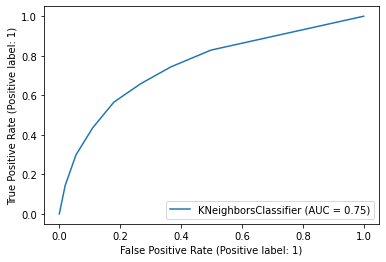

In [109]:
y_test,X_test=bestmodel_val_data
plot_roc_curve(bestmodel,X_test,y_test)

Smote works by using a random example from the minority class which is first chosen. Then k of the nearest neighbors for that example are found (k=5 is the default value which is used here). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space. Thus, smote is essentially overfitting our KNN classifier
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [110]:
bestscore=0
bestmodel,bestmodel_val_data=None,None
scores=[]
for train_index, test_index in cv.split(xs,y):
      X_train = xs[train_index]
      y_train = y[train_index]
      X_test = xs[test_index]
      y_test = y[test_index]
      sm = SMOTE()
      X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
      model = RandomForestClassifier(random_state=random_state)
      model.fit(X_train_oversampled, y_train_oversampled)  
      y_pred = model.predict_proba(X_test)[:,1]
      score=roc_auc_score(y_test,y_pred)
      scores.append(score)
      if score>bestscore:
            bestmodel=model
            bestscore,bestmodel_val_data=score,[y_test,X_test]
            print(f"RandomForestClassifier with best score of {score}")
score_df_smote["RandomForestClassifier"]=scores
print(f"RandomForestClassifier with avg score of {np.median(np.array(scores))}")

RandomForestClassifier with best score of 0.7843204069818259
RandomForestClassifier with best score of 0.7907226179684992
RandomForestClassifier with best score of 0.797352266884367
RandomForestClassifier with best score of 0.8021178994297268
RandomForestClassifier with best score of 0.8026743840127953
RandomForestClassifier with avg score of 0.7887226121720137


In [ ]:
fi = rf_feat_importance(bestmodel, feature_names)
fi[:10]

In [ ]:
plot_fi(fi)

c:\Users\siong hwee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


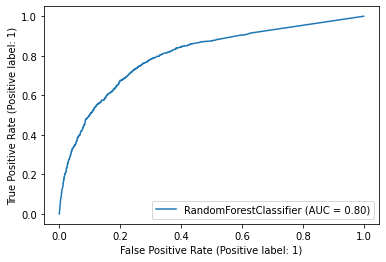

In [111]:
y_test,X_test=bestmodel_val_data
plot_roc_curve(bestmodel,X_test,y_test)

In [112]:
score_df_smote.to_csv("../content/score_smote.csv")

We could also try tomek links on knn and rf.

In [113]:
from imblearn.under_sampling import TomekLinks

In [114]:
#tomek link dataframe
score_df_tl=pd.DataFrame()

In [115]:
bestscore=0
bestmodel,bestmodel_val_data=None,None
scores=[]
# we stop at k ==9 as it seems that the knn auc roc score drops off at k=7
for i in range(1,10,2):
    scores=[]
    for train_index, test_index in cv.split(xs,y):
        X_train = xs[train_index]
        y_train = y[train_index]
        X_test = xs[test_index]
        y_test = y[test_index]
        tl = TomekLinks()
        X_train_undersampled, y_train_undersampled = tl.fit_resample(X_train, y_train)
        model = KNeighborsClassifier(i)
        model.fit(X_train_undersampled, y_train_undersampled)  
        y_pred = model.predict_proba(X_test)[:,1]
        score=roc_auc_score(y_test,y_pred)
        scores.append(score)
        if score>bestscore:
            bestmodel=model
            bestscore,bestmodel_val_data=score,[y_test,X_test]
            print(f"KNN {i} with best score of {score}")
    score_df_tl["KNN"+str(i)]=scores
    print(f"KNN {i} with avg score of {np.median(np.array(scores))}")

KNN 1 with best score of 0.6394402624563718
KNN 1 with best score of 0.651158653800867
KNN 1 with best score of 0.6581842169437382
KNN 1 with avg score of 0.6466452481142361
KNN 3 with best score of 0.7121791975203526
KNN 3 with best score of 0.7124123156917685
KNN 3 with best score of 0.7264477452181478
KNN 3 with best score of 0.728554490298224
KNN 3 with best score of 0.729308413748022
KNN 3 with avg score of 0.7201223694694859
KNN 5 with best score of 0.7363705391452943
KNN 5 with best score of 0.737917414468013
KNN 5 with avg score of 0.724461429031614
KNN 7 with avg score of 0.7177532601063841
KNN 9 with avg score of 0.7068583393392969


c:\Users\siong hwee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


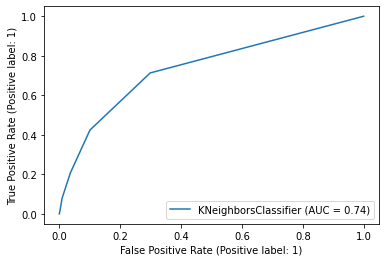

In [116]:
y_test,X_test=bestmodel_val_data
plot_roc_curve(bestmodel,X_test,y_test)

In [120]:
bestscore=0
bestmodel,bestmodel_val_data=None,None
scores=[]
for train_index, test_index in cv.split(xs,y):
      X_train = xs[train_index]
      y_train = y[train_index]
      X_test = xs[test_index]
      y_test = y[test_index]
      sm = SMOTE()
      X_train_undersampled, y_train_undersampled = tl.fit_resample(X_train, y_train)
      model = RandomForestClassifier(random_state=random_state)
      model.fit(X_train_undersampled, y_train_undersampled)   
      y_pred = model.predict_proba(X_test)[:,1]
      score=roc_auc_score(y_test,y_pred)
      scores.append(score)
      if score>bestscore:
            bestmodel=model
            bestscore,bestmodel_val_data=score,[y_test,X_test]
            print(f"RandomForestClassifier with best score of {score}")
score_df_tl["RandomForestClassifier"]=scores
print(f"RandomForestClassifier with avg score of {np.median(np.array(scores))}")

RandomForestClassifier with best score of 0.786336622482988
RandomForestClassifier with best score of 0.7939022044166589
RandomForestClassifier with best score of 0.7986730353433291
RandomForestClassifier with best score of 0.8012694475716108
RandomForestClassifier with best score of 0.8021922758216827
RandomForestClassifier with best score of 0.8038252099731968
RandomForestClassifier with best score of 0.8045463785398498
RandomForestClassifier with best score of 0.8048884376414299
RandomForestClassifier with avg score of 0.7919437157106285


c:\Users\siong hwee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


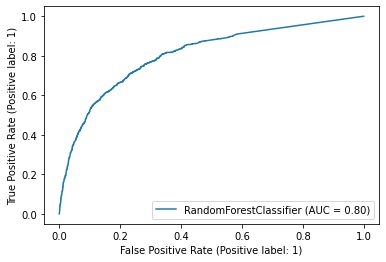

In [121]:
y_test,X_test=bestmodel_val_data
plot_roc_curve(bestmodel,X_test,y_test)

In [122]:
fi = rf_feat_importance(bestmodel, feature_names)
fi[:10]

,cols,imp
2,birth_day,0.225850
3,employment_length,0.195903
1,income,0.154938
36,job,0.035448
7,job,0.035408
8,CNT_FAM_MEMBERS,0.034578
5,phone,0.027925
0,num_child,0.025459
4,work_phone,0.021779
19,x3_Working,0.014646


<AxesSubplot:ylabel='cols'>

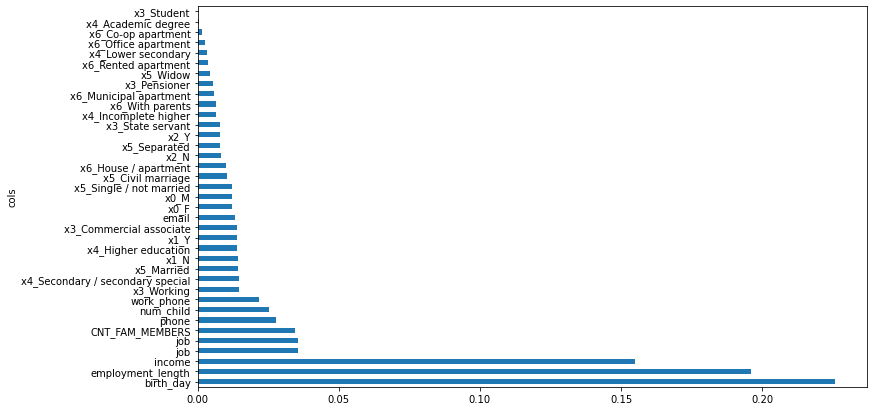

In [123]:
plot_fi(fi)

In [119]:
score_df_tl.to_csv("../content/score_tl.csv")